In [1]:
#Import modules 
import time as T
import matplotlib
import pandas as pd 
import numpy as np 
import torch
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

#Go to the parent folder AI II FINAL CODE as main path 
try: 
    import os
    if str(os.getcwd())[-16:] != "AI II FINAL CODE": 
        os.chdir('../../AI II FINAL CODE/')
except:
    pass 

Gradient function erfPlus() is correct
Gradient function erfRelu() is correct
Gradient function squarePlus() is correct
Gradient function degreePlus() is correct


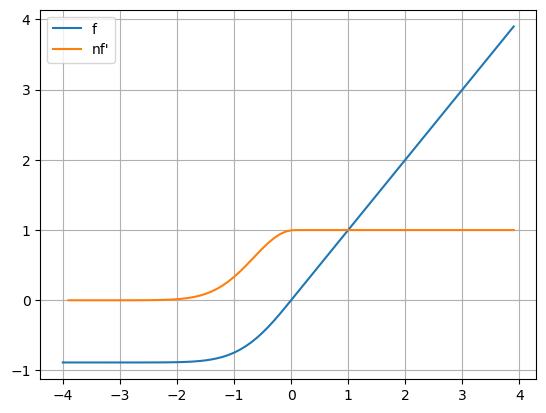

Using device: cuda


In [2]:
%run CurrentCode/Model2.ipynb
%run CurrentCode/actFunctions2.ipynb
%run CurrentCode/DeviceDataLoader2.ipynb

In [3]:
actFuncList = [nn.ReLU, nn.GELU, squarePlus,  nn.Softplus, erfRelu, erfPlus] 
actFuncList_str = ['relu', 'gelu', 'squarplus', 'softplus','erfrelu', 'erfplus'] 

df = pd.DataFrame(np.zeros((30, 6)), columns=actFuncList_str)

#Evaluate the model 
def evaluate(self, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [self.validation_step(batch) for batch in val_loader]
    return self.validation_epoch_end(outputs)

#Find the accuracy for validation 
def validation_step(self, batch):
    images, labels = batch 
    out = torch.round(self.forward(images))                 # Generate predictions
    loss = self.criterion(out, labels)         # Calculate loss
    acc = self.accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}
    
#plot the validation results 
def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

In [4]:
folder_path = "Models/Experiment1/"

prevActFunc = location = 0

with torch.inference_mode():
    for filename in os.listdir(folder_path):  # List all files
        file_path = os.path.join(folder_path, filename)  # Get full path
        if os.path.isfile(file_path):  # Ensure it's a file
            with open(file_path, 'r') as file:
                filenamelist = filename.split('_')
                actFunc = filenamelist[1] 
                if actFunc == prevActFunc:
                    location += 1 
                else: 
                    location = 0
                model = ResNet(block=ResidualBlock, img_input_dim=28, layers=50, actFunc=actFuncList[actFuncList_str.index(actFunc)])
                to_device(model, device)
                model.load_state_dict(torch.load(folder_path+filename, weights_only=True))
                model.eval()
                score = -np.log(1-model.evaluate(test_loader)['val_acc'])
                df.at[location, actFunc] = score 
                prevActFunc = actFunc
                
                print(f"filename: {filename} score: {score}", end="\r")

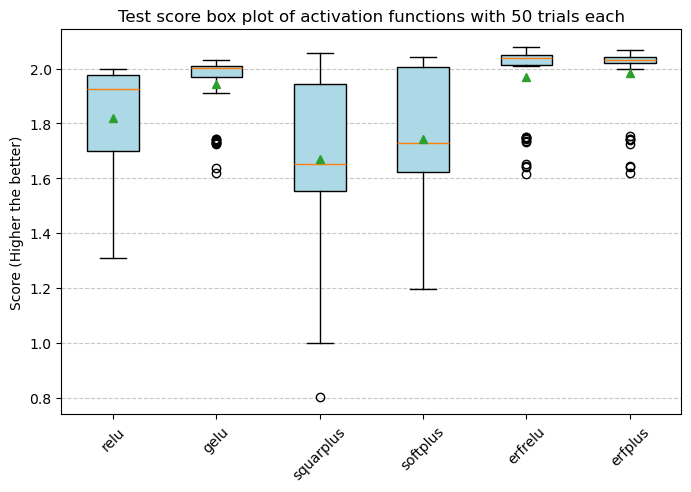

In [50]:

# Create the box plot
plt.figure(figsize=(8, 5))
plt.boxplot(df, patch_artist=True, boxprops=dict(facecolor="lightblue"), showmeans=True)

# Customize the plot
plt.xticks(ticks=range(1, len(actFuncList_str) + 1), labels=actFuncList_str, rotation=45)  # Set x-axis labels
plt.ylabel("Score (Higher the better)")
plt.title(f'Test score box plot of activation functions with {50} trials each')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [51]:

    
print("Final score values")
print('----------------------')
print(f"{("Act Func"):<10}: {("median "):<6} | {("max  "):<7} | {("mean"):<7} | {("std"):<6}")
for actFunc in actFuncList_str:
    print(f"{(actFunc):<10}: {(np.median(df[actFunc])):.5f} | {(np.max(df[actFunc])):.5f} | {(np.mean(df[actFunc])):.5f} | {(np.std(df[actFunc])):.5f}")

Final score values
----------------------
Act Func  : median  | max     | mean    | std   
relu      : 1.92565 | 1.99731 | 1.81965 | 0.17164
gelu      : 2.00211 | 2.03256 | 1.94409 | 0.11838
squarplus : 1.65340 | 2.05729 | 1.67189 | 0.29013
softplus  : 1.72795 | 2.04330 | 1.74453 | 0.23527
erfrelu   : 2.03868 | 2.07864 | 1.96814 | 0.14265
erfplus   : 2.03294 | 2.06672 | 1.98329 | 0.12570


In [7]:
def PD_evaluate(model1, model2, val_loader):
        """Evaluate the model's performance on the validation set"""
        outputs = torch.tensor([pred_difference(model1, model2, batch) for batch in val_loader]) 
        return torch.mean(outputs) 

#equation 2 of https://arxiv.org/pdf/2202.06499
def pred_difference(model1, model2, batch): 
        images, labels = batch 
        out1 = torch.round(model1.forward(images))                # Generate predictions for model 1 
        out2 = torch.round(model2.forward(images))               # Generate predictions for model 2 
        
        return torch.nanmean(2*torch.abs(out1-out2)/(out1+out2))

actFuncList_str = ['relu', 'gelu', 'squarplus', 'softplus','erfrelu', 'erfplus'] 

In [ ]:
def PD(activationFunction, test_loader, num=20): 

    folder_path = "Models/Experiment1/"

    modelLists = []

    location = 0

    with torch.inference_mode():
        
        for filename in os.listdir(folder_path):  # List all files
            filenamelist = filename.split('_')
            actFunc = filenamelist[1] 
            if actFunc == activationFunction:
                model = ResNet(block=ResidualBlock, img_input_dim=28, layers=50, actFunc=actFuncList[actFuncList_str.index(actFunc)])
                to_device(model, device)
                model.load_state_dict(torch.load(folder_path+filename, weights_only=True))
                model.eval()
                modelLists.append(model)
                location += 1 
                if location == num: 
                    print(actFunc)
                    break 
        
        PDlist = []
        
        for ii in range(num):
            for jj in range(num-ii-1):
                #print(f"{ii} {1+ii+jj}", end="\r")
                PDlist.append(PD_evaluate(modelLists[ii], modelLists[1+ii+jj], test_loader))
    
        return PDlist
            

In [ ]:
PDlists = [] 

for actFunc in actFuncList_str: 
    
    PDlists.append(PD(actFunc, test_loader, num=20)) 
    
PDlists = np.array(PDlists)

relu
gelu
squarplus
softplus
erfrelu
erfplus


In [55]:
PDlists.shape

(6, 190)

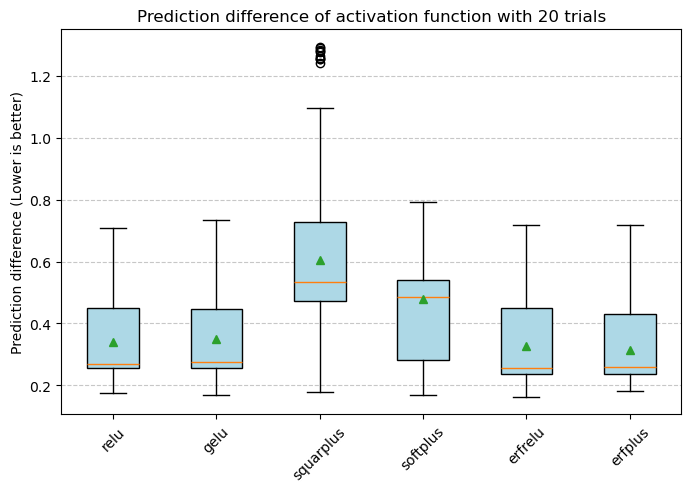

In [57]:

# Create the box plot
plt.figure(figsize=(8, 5))
plt.boxplot(PDlists.T, patch_artist=True, boxprops=dict(facecolor="lightblue"), showmeans=True)

# Customize the plot
plt.xticks(ticks=range(1, len(actFuncList_str) + 1), labels=actFuncList_str, rotation=45)  # Set x-axis labels
plt.ylabel("Prediction difference (Lower is better)")
plt.title("Prediction difference of activation function with 20 trials")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [59]:
print("Prediction difference values")
print('----------------------')
print(f"{("Act Func"):<10}: {("median "):<6} | {("max  "):<7} | {("mean"):<7} | {("std"):<6}")
for ii in range(len(actFuncList_str)):
    print(f"{(actFuncList_str[ii]):<10}: {(np.median(PDlists[ii])):.5f} | {(np.max(PDlists[ii])):.5f} | {(np.mean(PDlists[ii])):.5f} | {(np.std(PDlists[ii])):.5f}")

Prediction difference values
----------------------
Act Func  : median  | max     | mean    | std   
relu      : 0.27012 | 0.70986 | 0.33887 | 0.11674
gelu      : 0.27602 | 0.73277 | 0.34813 | 0.12000
squarplus : 0.53372 | 1.29313 | 0.60537 | 0.24558
softplus  : 0.48400 | 0.79128 | 0.47784 | 0.16960
erfrelu   : 0.25628 | 0.71649 | 0.32682 | 0.12078
erfplus   : 0.25896 | 0.71743 | 0.31518 | 0.11373


In [ ]:
len()

190

In [39]:
PDlists2 = [] 

for actFunc in actFuncList_str: 
    
    PDlists2.append(PD(actFunc, test_loader, num=5)) 
    
PDlists2 = np.array(PDlists2)

relu
tensor(0.)
gelu
tensor(0.)
squarplus
tensor(0.)
softplus
tensor(0.)


KeyboardInterrupt: 

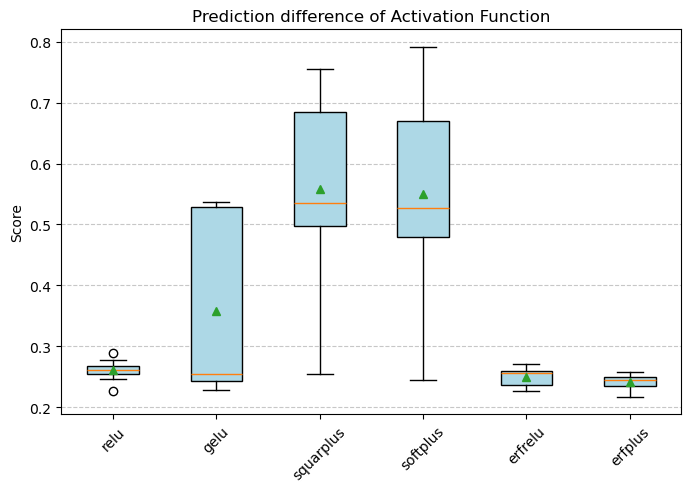

In [ ]:

# Create the box plot
plt.figure(figsize=(8, 5))
plt.boxplot(PDlists2.T, patch_artist=True, boxprops=dict(facecolor="lightblue"), showmeans=True)

# Customize the plot
plt.xticks(ticks=range(1, len(actFuncList_str) + 1), labels=actFuncList_str, rotation=45)  # Set x-axis labels
plt.ylabel("Score")
plt.title("Prediction difference of activation functions with 10 trials")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()